<h1 align="center"> Titanic Kaggle com AutoML </h1>
<p>Na minha ultima tentativa de participar do desafio do titanic do Kaggle eu sai um pouco desanimado com minha colocação, um pessimo 8080º lugar com 0,76 de score.</p>
<p>Após dar uma olhada no que eu fiz encontre varias coisas que eu podia melhorar, para começar quero resolver 2 problemas.<p>
<h2 align="center">overfitting</h2>
<img src="overfitting.jpg"  width="400"/>
<p>Meus algoritmos de Random Forest e Decision Tree tiveram pontuação muito alta, mais de 98%, e meu desempenho com o dataset de teste não foi tão bom, isso me faz pensar que estamos usando muitas variais que provavelmente estão deixando o algoritmo "acostumado" com o nosso dataset, vamos tentar amenizar esse problema removendo algumas colunas menos importantes do nosso dataset.<p>
<h2 align="center">Escolha Algoritmo Correto / Tunning</h2>
<p>Como o algoritmo de Random Forest tinha obtido a melhor pontuação nos testes envie a resposta obtidas com ele para o kaggle, não tenho certeza se foi a melhor escolha, e também não alterei nenhum parâmetro do algoritmo.<p>
<p>Para tentar resolver esse problema vou usar a ferramenta de AutoML da plataforma h2o.<p>


In [63]:
#importando Pandas S2
import pandas as pd
#importa matplotlib (graficos)
import matplotlib.pyplot as plt
#importando numpy
import numpy as np
#importando  random forest
from sklearn.ensemble import RandomForestClassifier
#importa selecionador de recursos com base na importancia
from sklearn.feature_selection import SelectFromModel
#importando H2O
import h2o
from h2o.automl import H2OAutoML

In [12]:
#importa dataset treino
df = pd.read_csv("data/df.csv")
#importa dataset teste
teste = pd.read_csv("data/teste.csv")
#mostra primeiras linhas dataset treino
df.head()

,Unnamed: 0,PassengerId,Survived,Sex,Age,Fare,Titulo_Master,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Nobre,Titulo_Oficial,Emb_C,Emb_Q,Emb_S,Classe_1,Classe_2,Classe_3,Tamanho_Familia,Sozinho
0,0,1,0,1,22.0,7.2500,0,0,1,0,0,0,0,0,1,0,0,1,2,0
1,1,2,1,0,38.0,71.2833,0,0,0,1,0,0,1,0,0,1,0,0,2,0
2,2,3,1,0,26.0,7.9250,0,1,0,0,0,0,0,0,1,0,0,1,1,1
3,3,4,1,0,35.0,53.1000,0,0,0,1,0,0,0,0,1,1,0,0,2,0
4,4,5,0,1,35.0,8.0500,0,0,1,0,0,0,0,0,1,0,0,1,1,1


<h2>Escolhendo colunas</h2>
<p>Vamos escolher quais colunas tem mais importancia e manter elas.</p>

In [80]:
#definindo dataframe teste
X_train = df.drop(['Survived', 'PassengerId', 'Unnamed: 0'], axis=1)
Y_train = df['Survived']
X_test = teste.drop(['PassengerId', 'Unnamed: 0'], axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 17), (891,), (418, 17))

In [27]:
#Treina algoritmo de random forest
rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rfc = rfc.fit(X_train, Y_train)

In [56]:
#salva importancia de cada coluna em um dataframe
colunas = pd.DataFrame()
colunas['colunas'] = X_train.columns
colunas['importancia'] = rfc.feature_importances_
colunas.sort_values(by=['importancia'], ascending=True, inplace=True)
colunas.set_index('colunas', inplace=True)

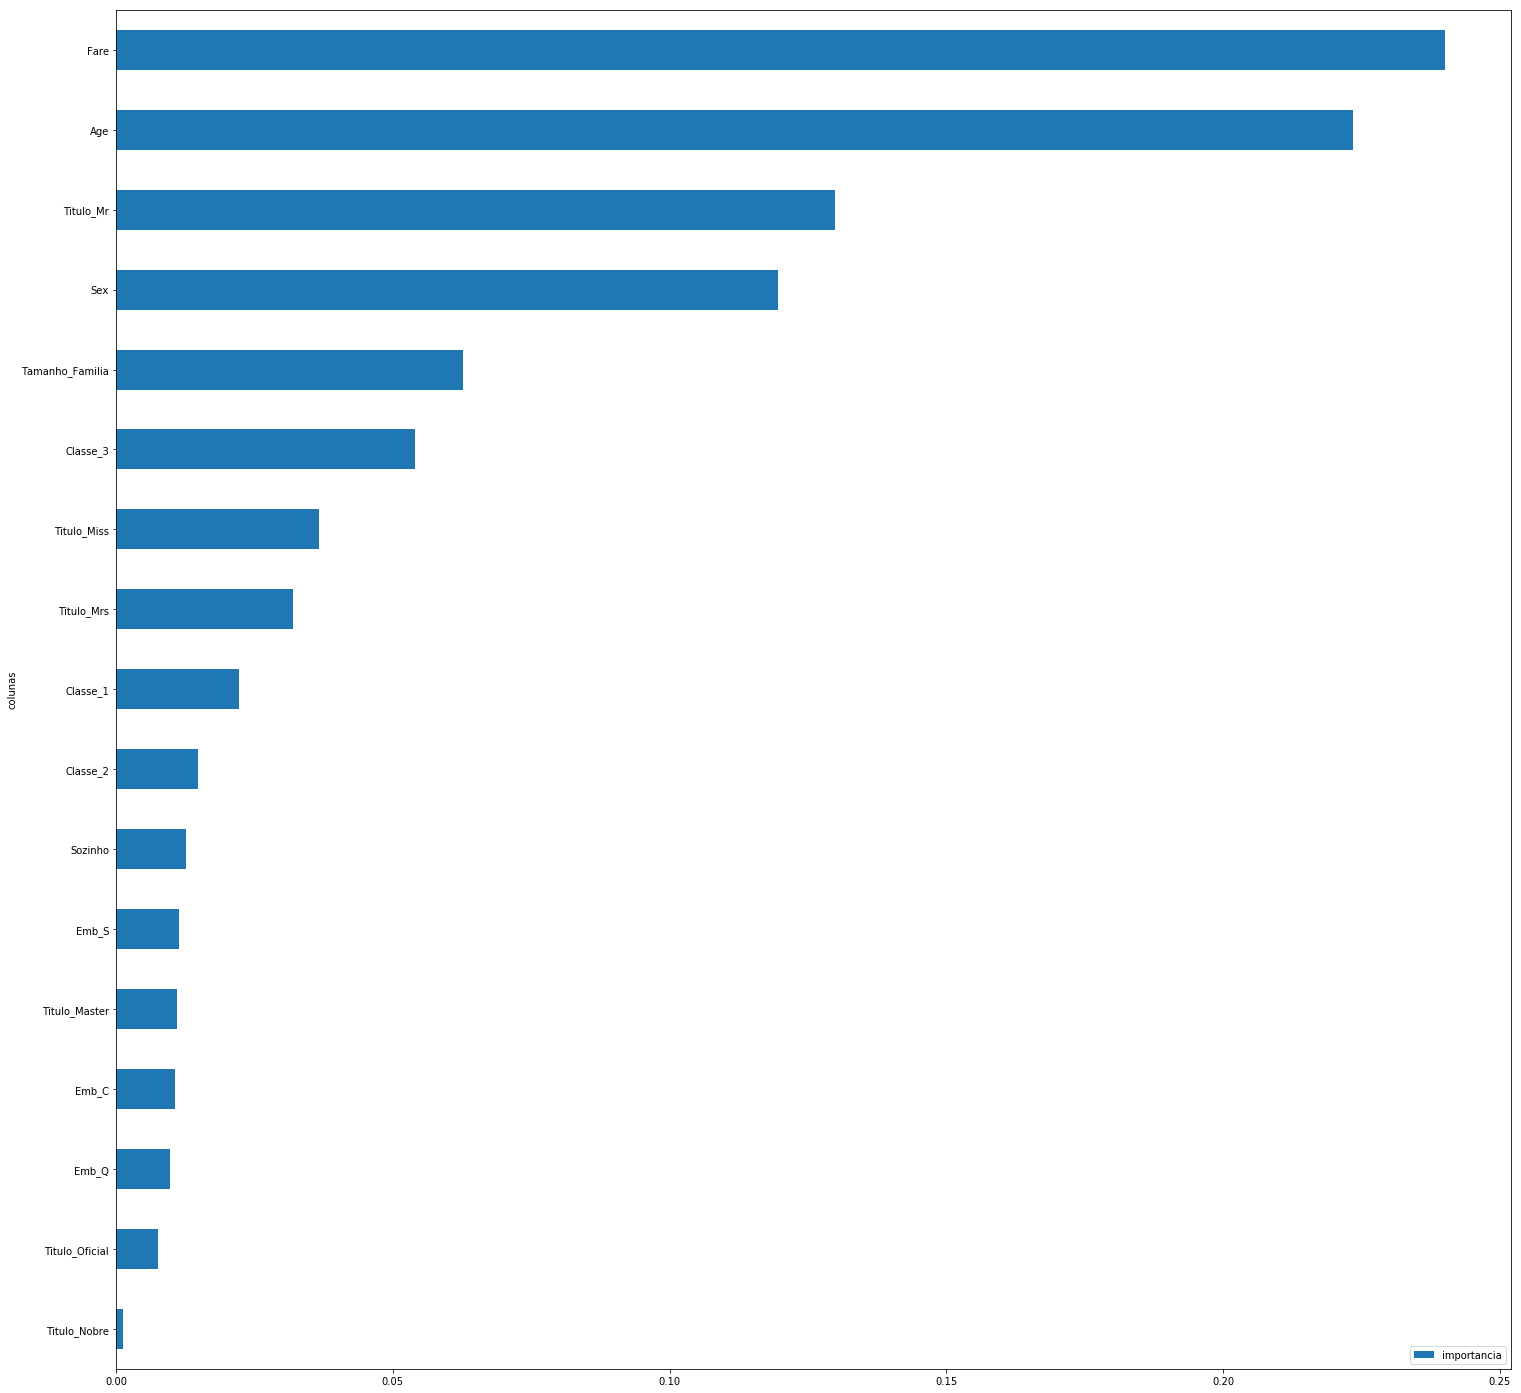

In [58]:
#monta grafico com a importancia de cada coluna
colunas.plot(kind='barh', figsize=(25, 25))

In [97]:
#Removendo colunas com menor importancia
modelo = SelectFromModel(rfc, threshold=0.01, prefit=True)
train_reduzido = modelo.transform(X_train)
print(train_reduzido.shape)

#test_reduzido = modelo.transform(X_test)
##print(test_reduzido.shape)

(891, 14)


<p>Com isso removemos as 3 colunas com menor importancia do nosso dataset, agora vamos testar a ferramenta de AutoML</p>

<h2>AutoML</h2>
Para rodar a ferramenta de AutoML precisamos iniciar um cluster, e também precisamos importar os dados para ele, infelizmente não achei uma maneira de usar um dataset do Pandas de maneira direta para rodar os aloritmos.

In [86]:
#inicia cluster 
#nthreads define o numero de núcleos usados 
#max_men_size define o maixmo de meoria usada 
h2o.init(nthreads = -1, max_mem_size= 6)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,21 secs
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,1 month and 22 days
H2O cluster name:,H2O_from_python_Samuel_dx5qwh
H2O cluster total nodes:,1
H2O cluster free memory:,5.325 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"locked, healthy"


In [96]:
treino_reduzido = pd.DataFrame(train_reduzido)
teste_reduzido = pd.DataFrame(test_reduzido)
teste_reduzido

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,34.5,7.8292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,47.0,7.0000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0
2,1.0,62.0,9.6875,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,1.0,27.0,8.6625,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,22.0,12.2875,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0
5,1.0,14.0,9.2250,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
6,0.0,30.0,7.6292,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
7,1.0,26.0,29.0000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0
8,0.0,18.0,7.2292,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
9,1.0,21.0,24.1500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0
